# 영화의 평점 예측해 보기

In [4]:
# 데이터를 필요에 따라 시각화 해 보면서...가능하면 의미있는 피처들을 추출
# - 피처들을 선택
#   - 1. 모든 피처를 학습
#   - 2. 피처의 중요도를 중요한 피처만 선택
#   - 3. 상관관계를 보고 제거
#   - 4. 수식에 참여한 (선형 회귀) ... 가중치들을 오름차순으로 배열한 후 단계적으로 제거하면서 재학습

# 다양한 머신러닝 알고리즘을 적용해서 성능 좋은 알고리즘을 채택
# - 교차분석, 파라미터튜이 (하이퍼파라미터)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Korean Font Settings in corab 

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath)
plt.rc('font', family='NanumBarunGothic') # size=9
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 97 not upgraded.


In [37]:
import matplotlib.pyplot as plt
sorted(set([i.name for i in mpl.font_manager.fontManager.ttflist]))
plt.rc('font', family='NanumBarunGothic')
# plt.rc('axes', labelsize=20)

In [6]:
# r_df = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/python/main/data/r.dat', delimiter='::')
# r_df.iloc[0,0].split('::')

r_df = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/python/main/data/r.dat',
                   sep='::', header=None)

m_df = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/python/main/data/m.dat',
                   sep='::', header=None, encoding='ISO-8859-1')

u_df = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/python/main/data/u.dat',
                   sep='::', header=None, encoding='ISO-8859-1')

# url 끝값 꼭 변수명과 같게 만들어 주어야 함
# 

# r_df.head()

In [7]:
# r_df.head().apply(lambda x : str(x).split('::'), axis=1)

In [8]:
r_df.columns = ['user_id', 'movie_id', 'rating', 'time'] # 영화 평점
m_df.columns = ['movie_id', 'title', 'genre'] # 영화 정보
u_df.columns = ['user_id', 'gender', 'age', 'occupation', 'zipcode'] # 유저 정보

In [9]:
m_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
u_df.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### 결측치는 반드시 처리해 주어야 함

In [11]:
# 널값 없는 것 확인
r_df.isna().sum(), m_df.isna().sum(), u_df.isna().sum()

(user_id     0
 movie_id    0
 rating      0
 time        0
 dtype: int64, movie_id    0
 title       0
 genre       0
 dtype: int64, user_id       0
 gender        0
 age           0
 occupation    0
 zipcode       0
 dtype: int64)

### 평점이 주이므로, 영화에 대한 데이터 추출하기

#### 평점이 등록된 영화의 수, 평점에 참여한 유저의 수, 각 평점의 히스토그램 구간 (평점이 후하거나, 박하거나)

In [12]:
# 영화의 고유번호가 중복되는 것이 있는지 확인

# np.unique(m_df['movie_id']) 
# m_df['movie_id'].value_counts()

# unique 값 : 3952
# 총 개수 : 3883

In [13]:
# 평점이 등록된 영화의 수
len(r_df['movie_id'].unique())

3706

In [14]:
len(m_df['movie_id']) # 참여를 하지 않은 유저가 있을 수도 있음

# 평점에 참여한 유저 수
len(r_df['user_id'].unique())

6040

### 각각의 수가 다르다. 어쩌면 평점이 등록되지 않은 영화가 있을 수도 있다.

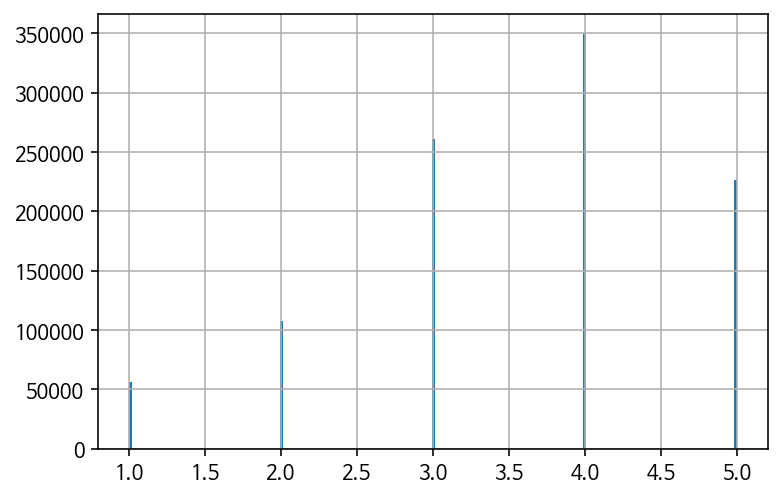

In [15]:
# 각 평점의 히스토그램 구간
r_df['rating'].hist(bins='auto') # --> 실수가 아니기 때문에 bar로만 표현됨
plt.show()

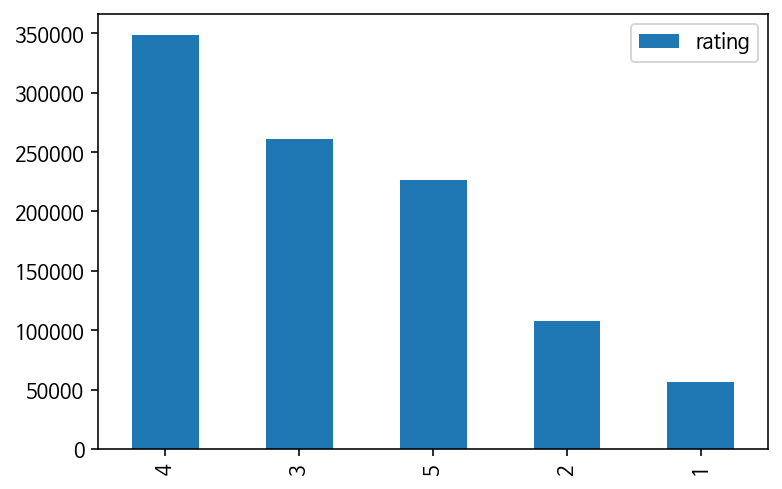

,rating
4,348971
3,261197
5,226310
2,107557
1,56174


In [16]:
r_df['rating'].value_counts() # 높이 정보 (Series 타입)
pd.DataFrame(r_df['rating'].value_counts()).plot.bar()
plt.show()

pd.DataFrame(r_df['rating'].value_counts())

### y값은 평점의 개수를 의미한다. 한 영화에 여러 평점이 등록되었을 것이다.

In [17]:
r_df['rating'].values, r_df['rating'].index

(array([5, 3, 3, ..., 5, 4, 4]), RangeIndex(start=0, stop=1000209, step=1))

In [18]:
# plt.bar(x=r_df['rating'].values, height=r_df['rating'].index) --> 너무 오래 걸림

### 장르별 영화 평점 살펴보기

- **소수가 높게 평가한 것과 다수가 낮게 평가한 것과는 차이가 있을 수 있음**
- **따라서 유저의 수와 평점의 수를 함께 따져보아야 함**

In [19]:
m_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
# r_df & m_df --> movie_id 공통컬럼을 만들어 주고, 이 컬럼을 기준으로 두 테이블을 합친 후
# 장르별로 groupby로 rating의 합과 user의 수를 구한다.

In [21]:
# merge OR concat
rm_merge_df = pd.merge(r_df, m_df, how='inner', on='movie_id') # r_df와 m_df를 내부적으로 movie_id를 기준으로 합치기
rm_merge_df.head()

,user_id,movie_id,rating,time,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


### 장르별로 평점에 참여한 유저의 수 출력

In [22]:
# rm_merge_df.groupby('genre')['rating', 'user_id']
# rating은 sum(), user_id는 count() 해 주어야 함 (id 고유값을 숫자로 연산해 버리기 때문)

# agg() : 여러 개 적용 가능한 함수
mr_merged_df = rm_merge_df.groupby('genre').agg({
    'rating' : 'sum',
    'user_id' : 'count'
})

mr_merged_df

,rating,user_id
genre,,
Action,41302,12311
Action|Adventure,38408,10446
Action|Adventure|Animation,1431,345
Action|Adventure|Animation|Children's|Fantasy,365,135
Action|Adventure|Animation|Horror|Sci-Fi,2192,618
...,...,...
Sci-Fi|Thriller|War,963,280
Sci-Fi|War,6083,1367
Thriller,63476,17851


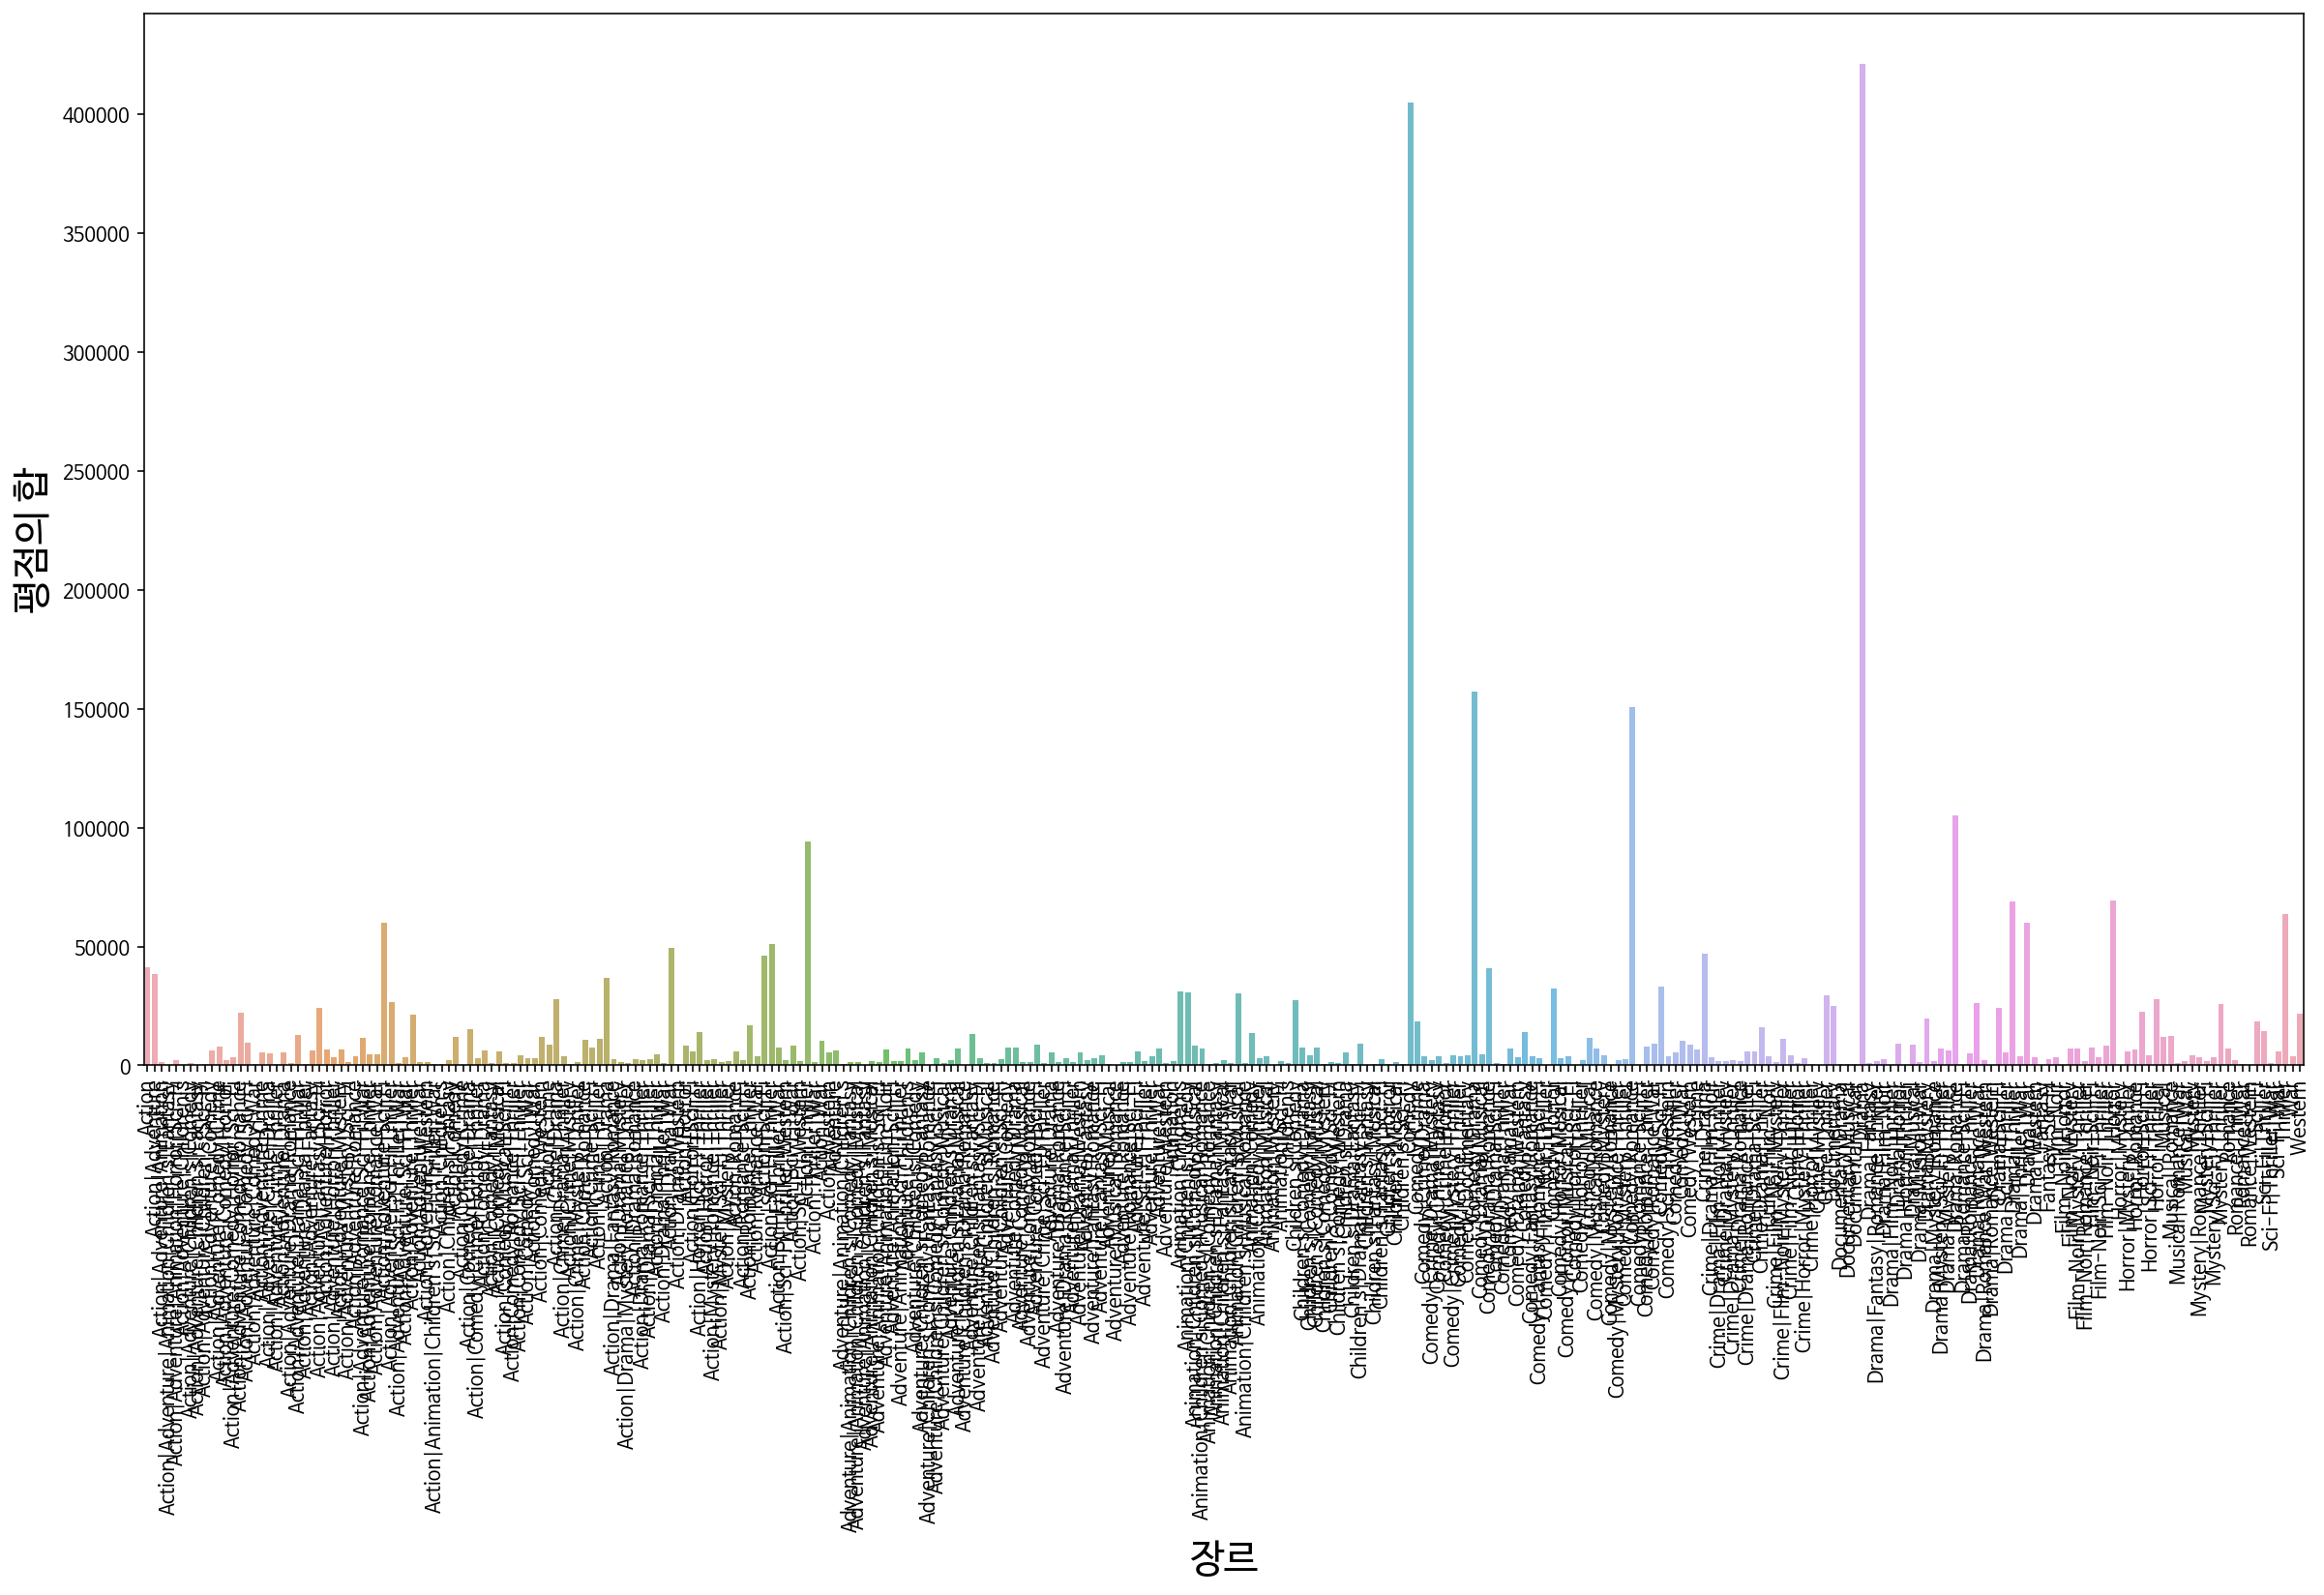

In [39]:
# 영화 장르 출력
# mr_merged_df['rating'].plot.bar()

import seaborn as sns
plt.figure(figsize=(20,10))
ax = sns.barplot(mr_merged_df['rating'].index, mr_merged_df['rating'].values, alpha=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xlabel('장르') # 한글 패치 필요
plt.ylabel('평점의 합')
plt.show()

### 전체를 보는 것은 양이 많고 가시성이 떨어지기 때문에 차라리 상위 x%로 보는 것이 효율적이다.

### 상위 100개만 출력하기

In [40]:
mr_merged_df.sort_values(by='rating', ascending=False).head(100)

,rating,user_id
genre,,
Drama,421247,111423
Comedy,404936,116883
Comedy|Drama,157175,42245
Comedy|Romance,150812,42712
Drama|Romance,105170,29170
...,...,...
Action|Adventure|Horror,6527,1932
Action|Adventure|Mystery,6527,1906
Action|Adventure|Comedy,6429,2077


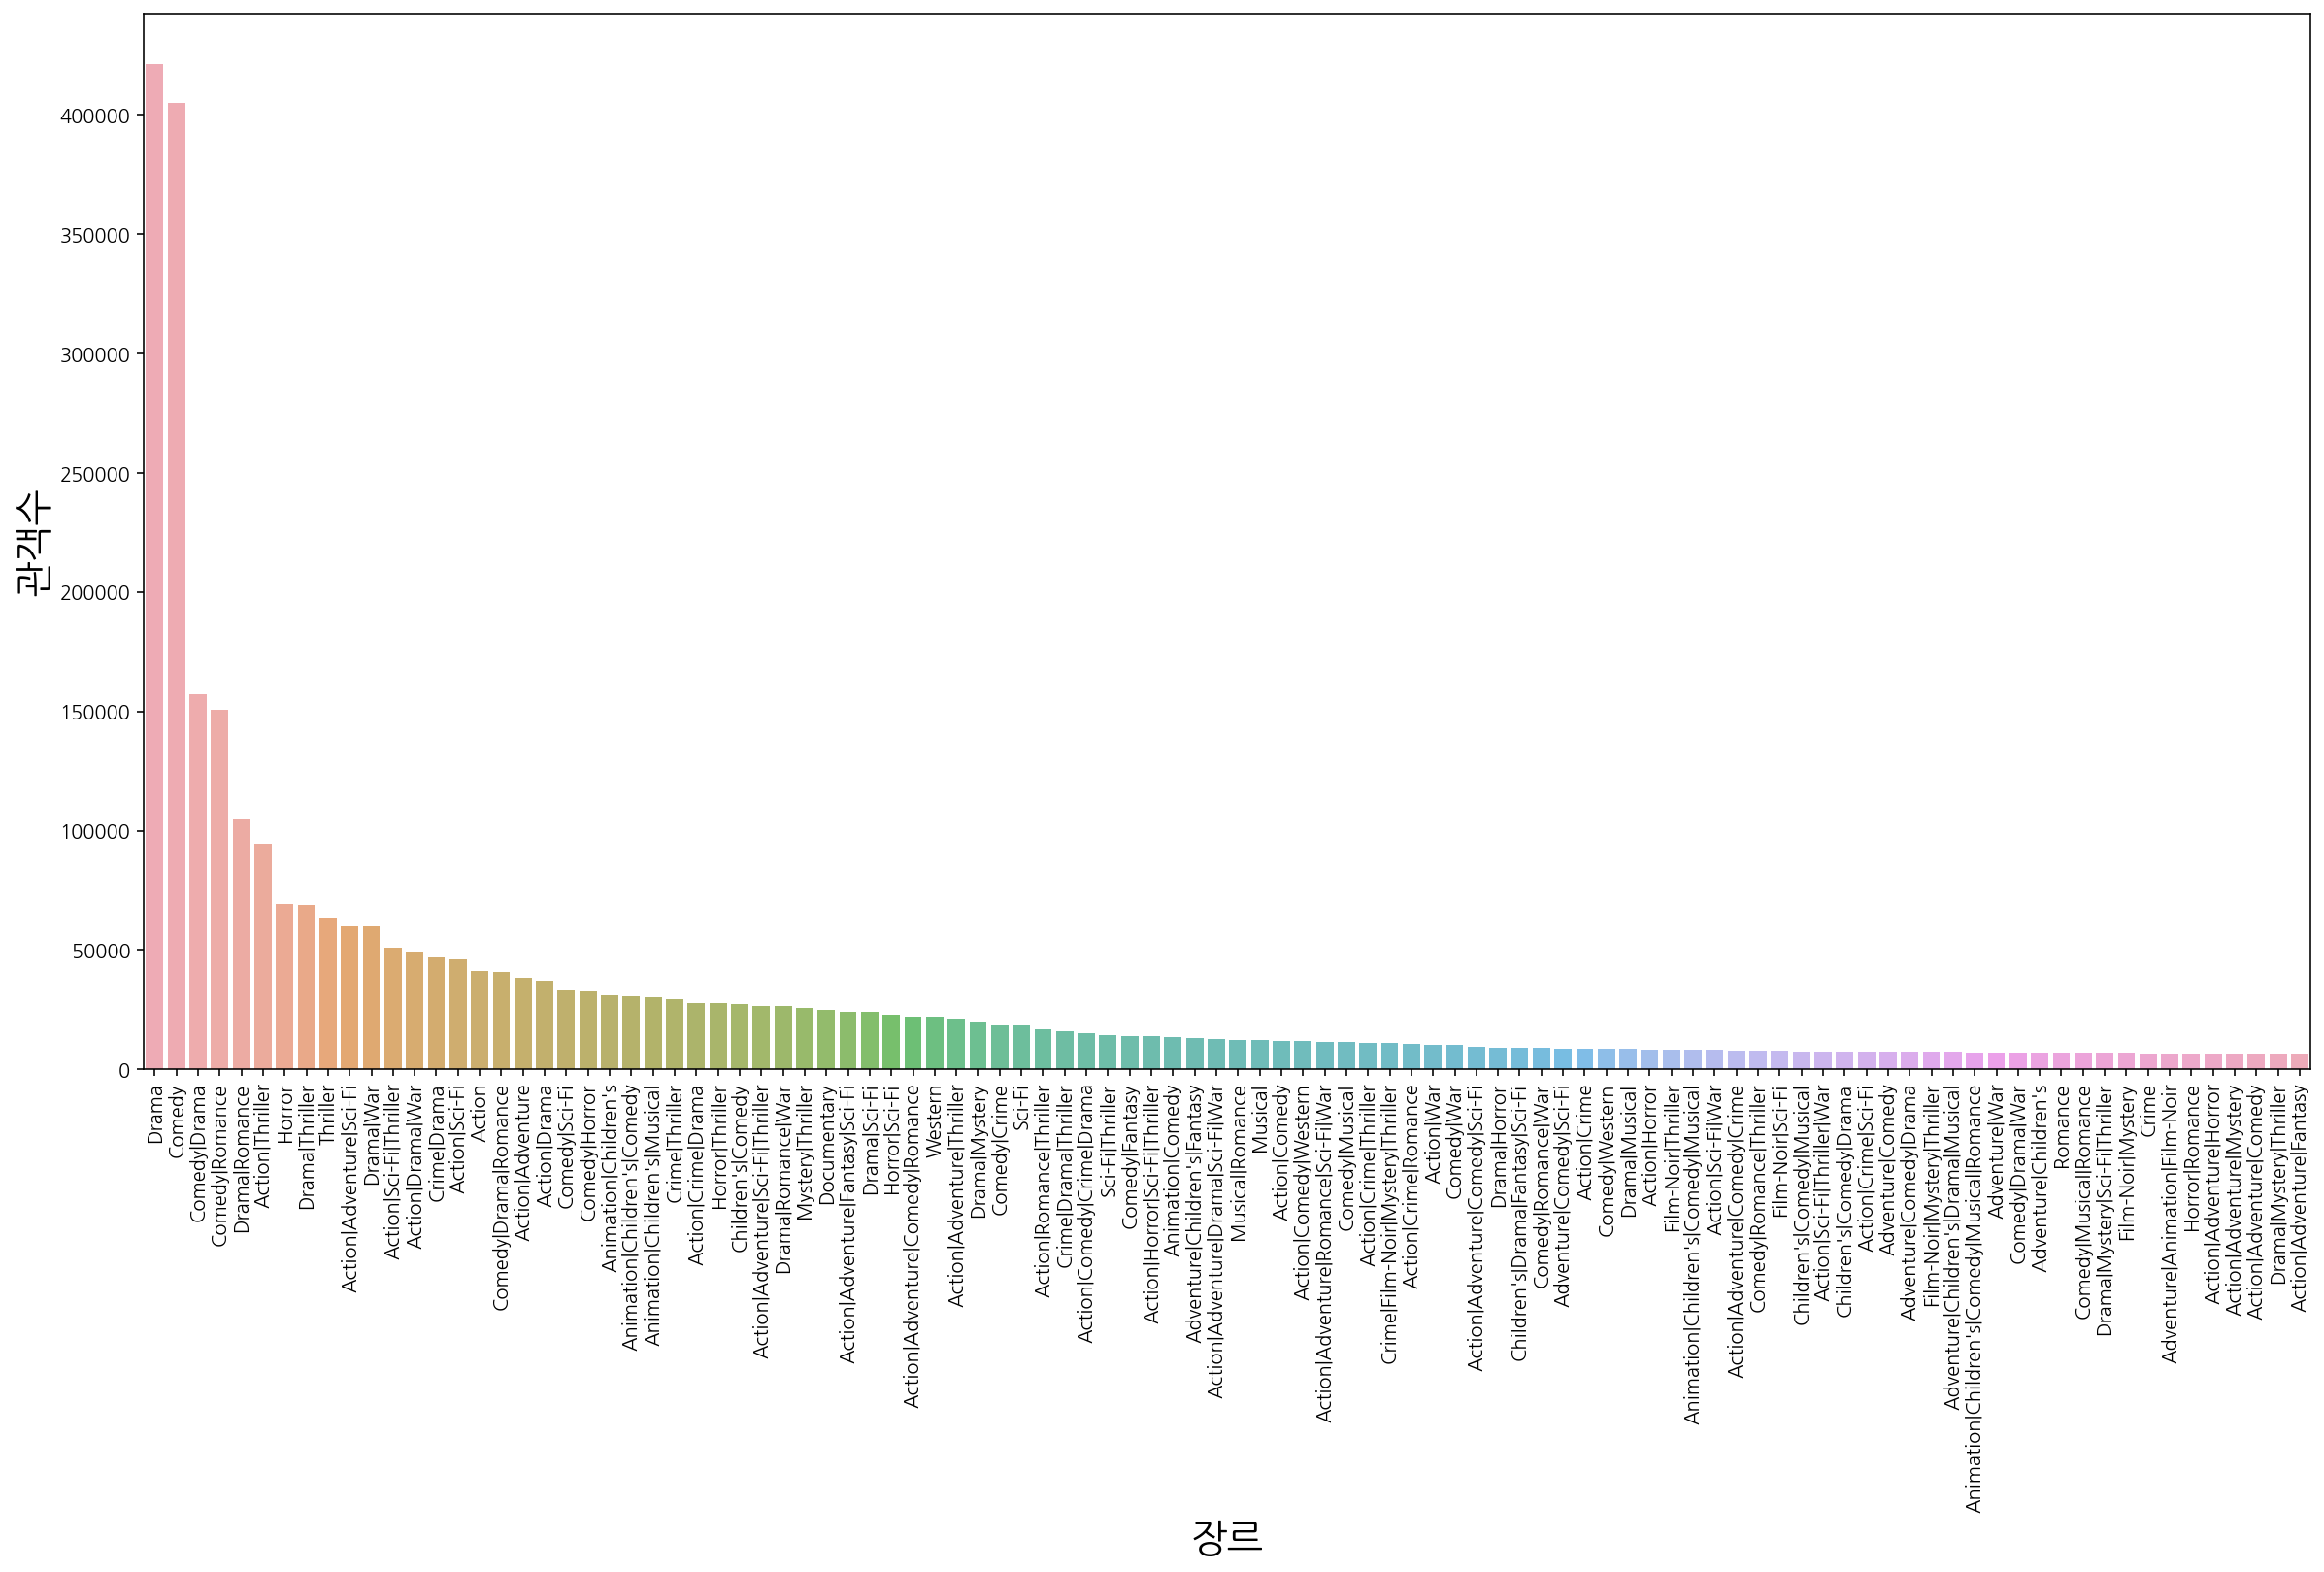

In [85]:
ratingTop100 = mr_merged_df.sort_values(by='rating', ascending=False).head(100)

import matplotlib as mpl
mpl.rc('font',family='NanumGothic')
plt.rc('axes', labelsize=20)

import seaborn as sns
plt.figure(figsize=(20,10))
ax = sns.barplot(ratingTop100['rating'].index, ratingTop100['rating'].values, alpha=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xlabel('장르') # 한글 패치 필요
plt.ylabel('관객수')
plt.show()

### 아까보다 훨씬 가시적인 그래프가 출력됨

### 상위 50개만 출력하기

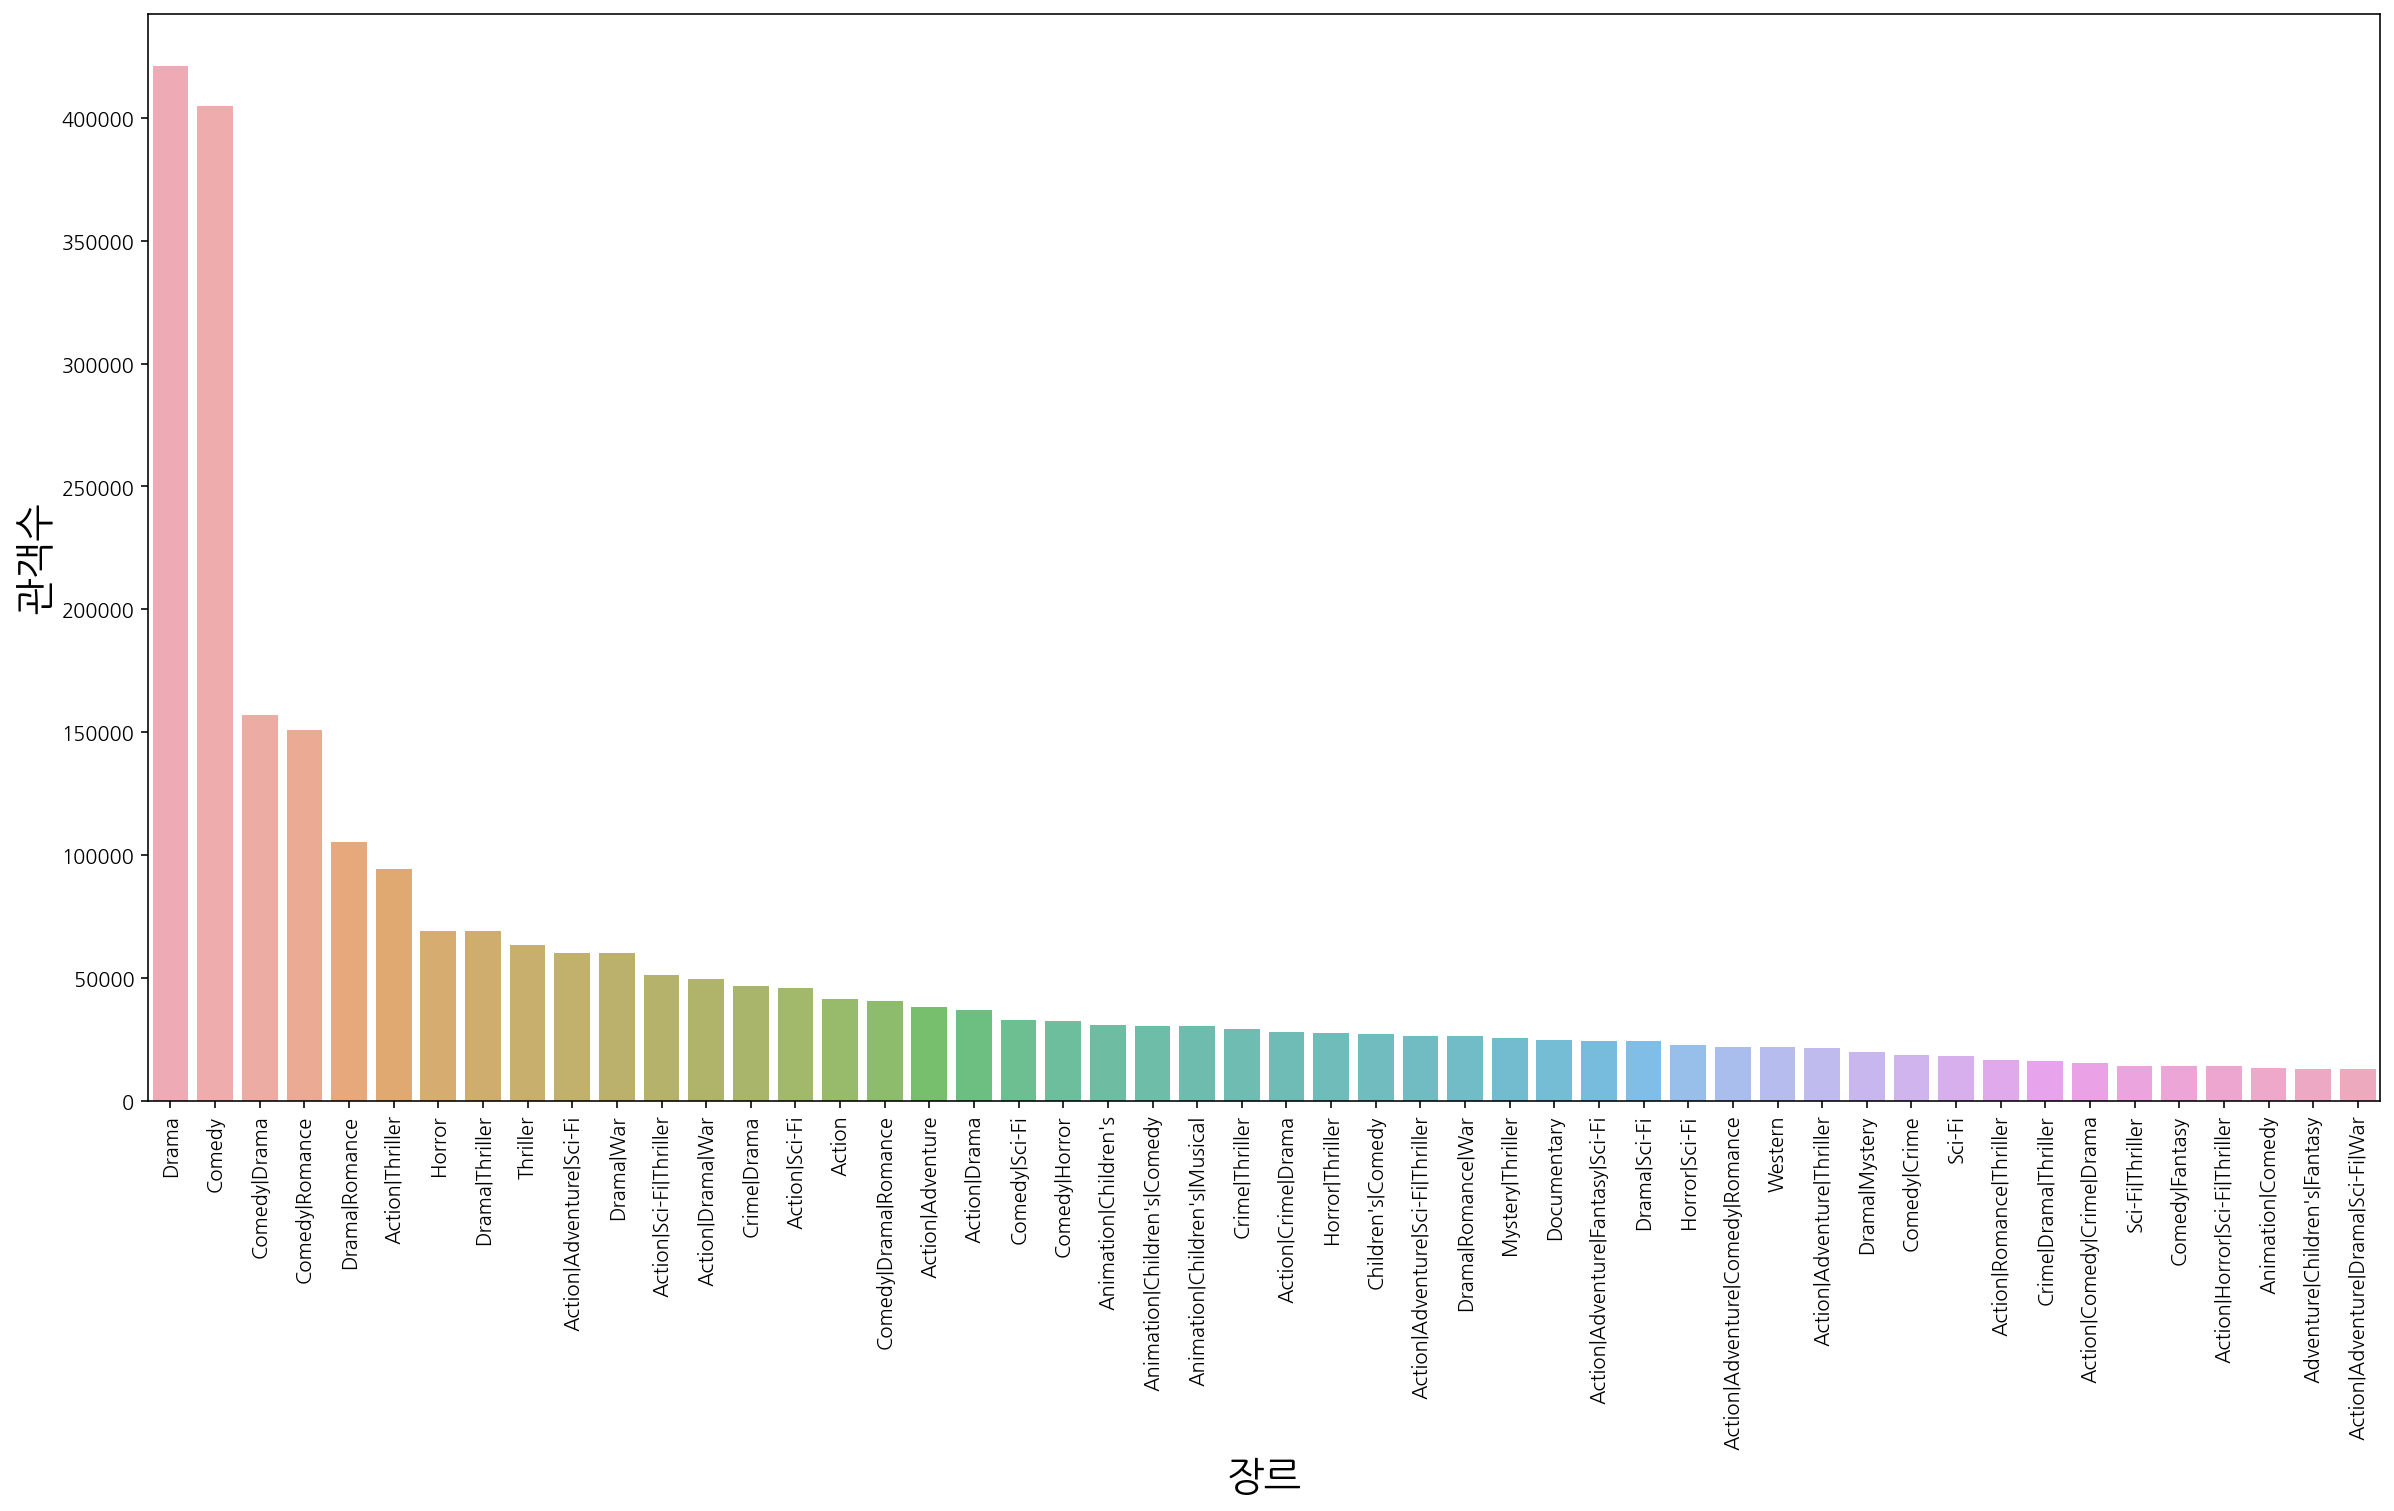

In [86]:
# 폰트 크기는 한 번 설정해 주면 다음 그래프에는 자동 적용됨
ratingTop50 = mr_merged_df.sort_values(by='rating', ascending=False).head(50)

import seaborn as sns
plt.figure(figsize=(20,10))
ax = sns.barplot(ratingTop50['rating'].index, ratingTop50['rating'].values, alpha=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xlabel('장르') # 한글 패치 필요
plt.ylabel('관객수')
plt.show()

### 사용자의 성별 분포

In [43]:
u_df['gender'].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

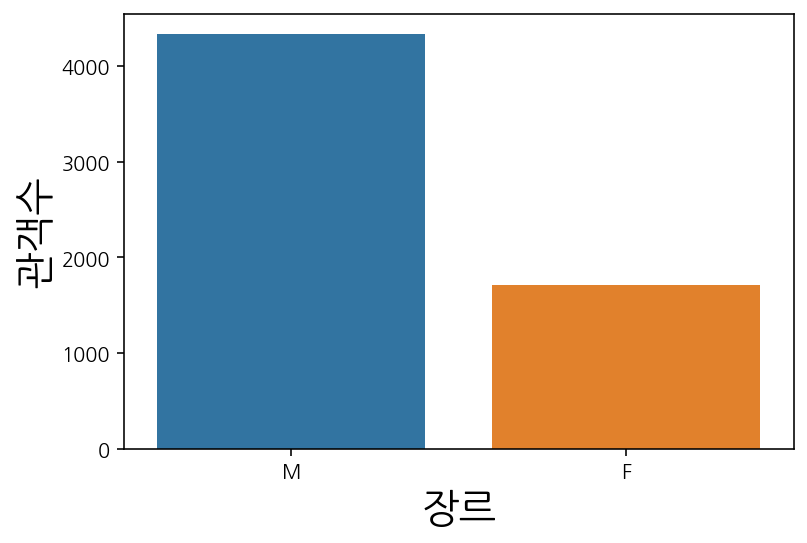

In [44]:
sns.barplot(u_df['gender'].value_counts().index, u_df['gender'].value_counts().values)
plt.rc('axes', labelsize=10)
plt.xlabel('장르')
plt.ylabel('관객수')
plt.show()

### 사용자의 나이 분포

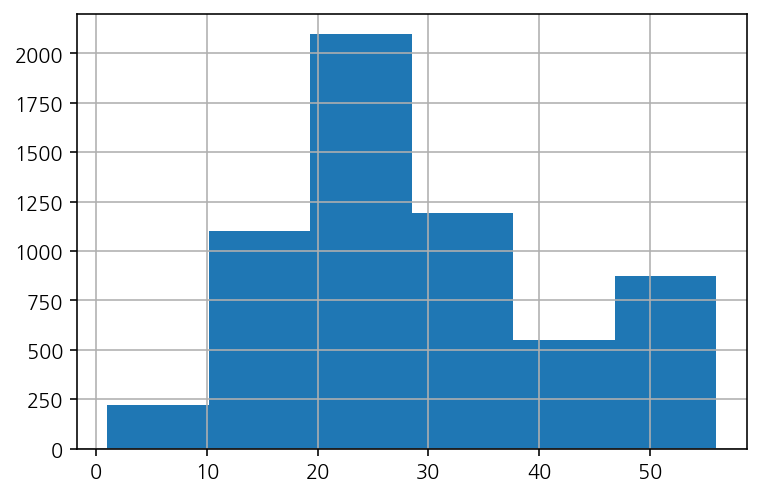

In [45]:
u_df['age'].hist(bins=6)
plt.show()

#### 나이대는 대략 10대~40대까지 가장 많은 비율을 차지함

### 영화별 평균 평점

In [46]:
temp = rm_merge_df.groupby('genre')['rating'].agg(['count'], ['mean'])
# temp.sort_values(by='count', axcending=False).head(10)
temp

,count
genre,
Action,12311
Action|Adventure,10446
Action|Adventure|Animation,345
Action|Adventure|Animation|Children's|Fantasy,135
Action|Adventure|Animation|Horror|Sci-Fi,618
...,...
Sci-Fi|Thriller|War,280
Sci-Fi|War,1367
Thriller,17851


### 예측하기
1. 유저별 평가한 영화의 개수
2. 유저별 평가한 평균 영화 점수
3. 유저별 평가한 영화 점수 편차

In [47]:
u_groupby_info = r_df.groupby('user_id')['rating'].agg(['count','mean', 'std'])
u_groupby_info

,count,mean,std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699
...,...,...,...
6036,888,3.302928,1.023684
6037,202,3.717822,0.877910
6038,20,3.800000,1.105013


### 컬럼명 정제

In [48]:
u_groupby_info.columns = ['rating_count', 'rating_mean', 'rating_std']
u_groupby_info

,rating_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699
...,...,...,...
6036,888,3.302928,1.023684
6037,202,3.717822,0.877910
6038,20,3.800000,1.105013


### 히스토그램

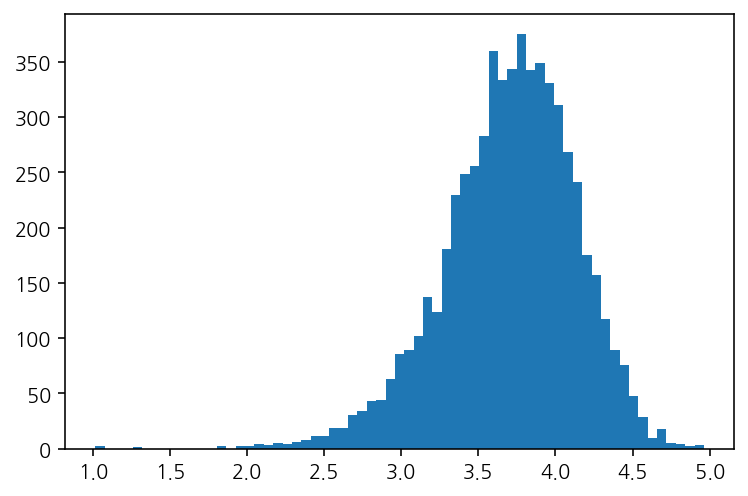

In [49]:
u_groupby_info['rating_mean'].hist(bins='auto', grid=False) # 격자 제거
plt.show()

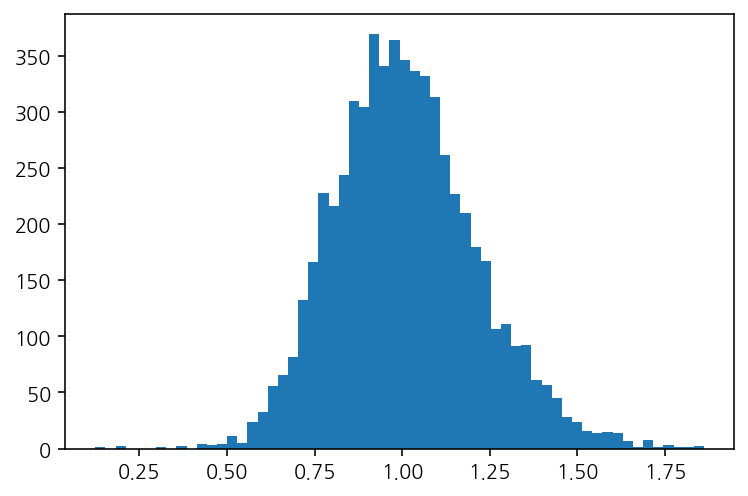

In [50]:
u_groupby_info['rating_std'].hist(bins='auto', grid=False) # 격자 제거
plt.show()

In [51]:
r_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### < Pivot Table > : user_id의 rating --> (x)  /  movie_id(y) rating --> (y)

In [52]:
r_df_pivot = r_df.pivot(index='user_id', columns='movie_id', values='rating')
r_df_pivot.head()

# 1번 유저는 1번 영화를 평가
# 5번 유저는 6번 영화를 평가
#           .
#           .
#           .

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## surprise 라이브러리
#### 사용자 기반 추천 시스템 구현을 사용하는 라이브러리
#### 사이킷런과 사용 방법이 유사

In [53]:
# 노트북 --> !pip install surprise
# 콘솔창 --> conda install -c conda-forge scikit-surprise

## SVD 특이값 분해 : 행렬 분해 중 가장 많이 사용하는 방법
### surprise를 이용하여 사용

In [54]:
!pip install surprise
from surprise import SVD, Reader, accuracy, Dataset
from surprise.model_selection import train_test_split

In [55]:
# temp_df = r_df[['user_id', 'movie_id', 'rating']][:100000]

# DataFrame 섞기
temp_df = r_df[['user_id','movie_id','rating']].sample(frac=1)
temp_df = temp_df[:10000]
len(temp_df)

10000

#### 평점의 범위가 1~5인 Reader 객체 생성하기

In [56]:
reader = Reader(rating_scale=(1,5))

#### surprise 형태의 데이터 구조로 변환시키는 함수

In [57]:
data = Dataset.load_from_df(temp_df, reader)

In [58]:
train_data = data.build_full_trainset()

In [59]:
train_data # surprise 형태의 데이터셋 생성

### SVD 모델 학습

In [60]:
model = SVD(
    n_factors = 8,
    lr_all = 0.005,
    reg_all = 0.02,
    n_epochs=10
)

model.fit(train_data)

# 평가하지 않은 유저 예측

### build_anti_testset() :

- 학습에 사용된 matrix 구조의 데이터에서 0으로 평가되어 있는 부분의 데이터(rating : 0)를
  'user 또는 item은 학습에 반드시 등장한 적이 있어야 한다'는 전제조건을 통해 추출

- 유저 기반으로 나와 비슷한 다른 유저의 성향을 분석해서 나도 그럴 것이라는 예측을 할 수 있는 메소드

- 유저가 평가하지 않은 값을 예측하는 데이터를 반환하는 함수

- **즉 pivot의 'NaN'값을 채워주는 함수**

In [61]:
# 학습에 사용된 유저나 아이템 --> 점수가 매겨져 있지 않은 데이터를 의미

test_data = train_data.build_anti_testset()
predict = model.test(test_data)

In [62]:
predict[:5]

# 빈 공간의 점수를 예측한 값
# r_ui : 원래 값         est : 예측한 값       iid : item의 아이디

[Prediction(uid=3002, iid=3760, r_ui=3.5723, est=3.690098217599565, details={'was_impossible': False}),
 Prediction(uid=3002, iid=23, r_ui=3.5723, est=3.5681446121821203, details={'was_impossible': False}),
 Prediction(uid=3002, iid=1957, r_ui=3.5723, est=3.8005905494689123, details={'was_impossible': False}),
 Prediction(uid=3002, iid=2160, r_ui=3.5723, est=3.7038319732352525, details={'was_impossible': False}),
 Prediction(uid=3002, iid=2098, r_ui=3.5723, est=3.625896407465406, details={'was_impossible': False})]

#### for문 이용하여 빈공간의 점수 예측한 값 가져오기

In [63]:
for _,iid,_,predict_rate,_ in predict[:10]: # 필요없는 데이터는 변수명을 (_)로 지정하여 사용하지 않음
    print(f'item id : {iid}, predict_rate : {predict_rate}')

item id : 3760, predict_rate : 3.690098217599565
item id : 23, predict_rate : 3.5681446121821203
item id : 1957, predict_rate : 3.8005905494689123
item id : 2160, predict_rate : 3.7038319732352525
item id : 2098, predict_rate : 3.625896407465406
item id : 457, predict_rate : 3.875926392673858
item id : 3753, predict_rate : 3.7944614441645106
item id : 2531, predict_rate : 3.481336040453907
item id : 3524, predict_rate : 3.6328549616364003
item id : 161, predict_rate : 3.5082719552613826


In [64]:
test_a = {'a':10, 'b':200, 'c':3000}
      # {'a':10, 'b':300, 'c':3000},
      # {'a':10, 'b':400, 'c':3000},
      # {'a':10, 'b':500, 'c':3000},
      # {'a':10, 'b':600, 'c':3000}


for key, value in test_a.items():
    if key == 'b':
      print(value)

# 즉 변수명은 중복되어도 상관없다.
# 파이썬에서는 변수명 중복 선언이라는 개념 자체가 없다.
# 따라서 위 for문에서 필요없는 데이터를 받아올 때 언더바(_)로 처리해 주어도 전혀 문제가 없다.

200


In [65]:
# 리스트 내의 딕셔너리 추출하기
# 리스트명[인덱스][key]

test_a = [{'a':10, 'b':200, 'c':3000},
        {'a':20, 'b':300, 'c':3000},
        {'a':10, 'b':400, 'c':3000},
        {'a':10, 'b':500, 'c':3000},
        {'a':10, 'b':600, 'c':3000}]


for i in range(5):
    print(test_a[i]['b'])


200
300
400
500
600


### **build_test_set()**
- 학습에 사용된 matrix 구조의 데이터에서 0으로 평가되어 있는 부분의 데이터(rating 0)를 'user, item은 학습에 반드시 등장한 적이 있어야 한다'는 전제조건을 통해 추출

- 유저기반으로 나와 비슷한 다른 유저의 성향을 분석해서 나도 그럴 것이라는 예측을 할 수 있는 메소드

- 유저가 평가한 값을 예측하는 데이터를 반환하는 함수

In [66]:
test_data = train_data.build_anti_testset()
predict = model.test(test_data)

# 원래부터 비어있지 않은 행열달의 값들을 출력
for _,iid, r_ui, predict_rate,_ in predict[:10]: # 필요없는 데이터는 변수명을 (_)로 지정하여 사용하지 않음
    print(f'item id : {iid}, real rating : {r_ui}, predict_rate : {predict_rate}')

item id : 3760, real rating : 3.5723, predict_rate : 3.690098217599565
item id : 23, real rating : 3.5723, predict_rate : 3.5681446121821203
item id : 1957, real rating : 3.5723, predict_rate : 3.8005905494689123
item id : 2160, real rating : 3.5723, predict_rate : 3.7038319732352525
item id : 2098, real rating : 3.5723, predict_rate : 3.625896407465406
item id : 457, real rating : 3.5723, predict_rate : 3.875926392673858
item id : 3753, real rating : 3.5723, predict_rate : 3.7944614441645106
item id : 2531, real rating : 3.5723, predict_rate : 3.481336040453907
item id : 3524, real rating : 3.5723, predict_rate : 3.6328549616364003
item id : 161, real rating : 3.5723, predict_rate : 3.5082719552613826


### 영화 점수 예측
### SVD 이용하여 데이터셋 생성
### 평점의 범위가 1~5인 Reader 객체 생성

In [67]:
import time
# 영화 점수를 예측
# SVD를 이용해서 데이터셋을 생성
# 평점의 범위가 1 ~ 5인 Reader 객체를 생성
reader =  Reader(rating_scale=(1,5))
temp_df = r_df[['user_id','movie_id','rating']].sample(frac=1)[:100000]
data = Dataset.load_from_df( pd.DataFrame(temp_df),reader )
train_data =  data.build_full_trainset()

# SVD 모델 학습
start = time.time()
model = SVD(
    n_factors=8,
    lr_all=0.005,
    reg_all=0.02,
    n_epochs=100
)
model.fit(train_data)
end = time.time()
print(f"학습에 걸린 시간 {end-start}")

학습에 걸린 시간 16.30985426902771


In [68]:
# 평가대상의 유저를 선택
target_user_id = 2
target_user_data =  r_df[r_df['user_id'] == 2]
target_user_data

,user_id,movie_id,rating,time
53,2,1357,5,978298709
54,2,3068,4,978299000
55,2,1537,4,978299620
56,2,647,3,978299351
57,2,2194,4,978299297
...,...,...,...,...
177,2,356,5,978299686
178,2,1245,2,978299200
179,2,1246,5,978299418
180,2,3893,1,978299535


In [69]:
# target_user_id = 2 유저가 평가한 영화의 평점  dic   movie_id : rating
# 2인 유저가 본 영화에 대한 평점
target_user_dic = {}
for i in target_user_data.values:
    target_user_dic[i[1]] = i[2]
    
print(target_user_dic)

{1357: 5, 3068: 4, 1537: 4, 647: 3, 2194: 4, 648: 4, 2268: 5, 2628: 3, 1103: 3, 2916: 3, 3468: 5, 1210: 4, 1792: 3, 1687: 3, 1213: 2, 3578: 5, 2881: 3, 3030: 4, 1217: 3, 3105: 4, 434: 2, 2126: 3, 3107: 2, 3108: 3, 3035: 4, 1253: 3, 1610: 5, 292: 3, 2236: 5, 3071: 4, 902: 2, 368: 4, 1259: 5, 3147: 5, 1544: 4, 1293: 5, 1188: 4, 3255: 4, 3256: 2, 3257: 3, 110: 5, 2278: 3, 2490: 3, 1834: 4, 3471: 5, 589: 4, 1690: 3, 3654: 3, 2852: 3, 1945: 5, 982: 4, 1873: 4, 2858: 4, 1225: 5, 2028: 4, 515: 5, 442: 3, 2312: 3, 265: 4, 1408: 3, 1084: 3, 3699: 2, 480: 5, 1442: 4, 2067: 5, 1265: 3, 1370: 5, 1193: 5, 1801: 3, 1372: 3, 2353: 4, 3334: 4, 2427: 2, 590: 5, 1196: 5, 1552: 3, 736: 4, 1198: 4, 593: 5, 2359: 3, 95: 2, 2717: 3, 2571: 4, 1917: 3, 2396: 4, 3735: 3, 1953: 4, 1597: 3, 3809: 3, 1954: 5, 1955: 4, 235: 3, 1124: 5, 1957: 5, 163: 4, 21: 1, 165: 3, 2321: 3, 1090: 2, 380: 5, 2501: 5, 349: 4, 457: 4, 1096: 4, 920: 5, 459: 3, 1527: 4, 3418: 4, 1385: 3, 3451: 4, 3095: 4, 780: 3, 498: 3, 2728: 3, 200

In [70]:
# 유저 2번이 안본 영화에대한 데이터
'''
movie_id  user_id
100        2
100        3        
100        2
200        2
300        2

위와 같은 데이터가 있다고 가정 )

  r_df[r_df['user_id'] != 2] 수행하면 
    - 결과: 100,200,300  --> 100은 2가 본 영화임에도 출력됨
      (중복된 movie_id가 있을 경우 2와 3이 각각 본 영화라면 2가 보지 않은 영화에도 포함될 수 있음)

따라서,
  non_target_data =  r_df[r_df['user_id'] != 2]
  r_df.head()
이와 같이 하면 안 됨

id가 2번인 유저가 본 영화 리스트를 r_df에서 추출한 다음
그 영화리스트를 m_df 와 비교 후 없는 영화리스트를 추출하면 된다.
'''

# for문 이용
non_target_user_data = []
list(target_user_dic.keys())
for i in m_df.values:
    if i[0] not in target_user_dic.keys():
        non_target_user_data.append(i[0])

# 검증
print(target_user_dic.keys() in non_target_user_data)  

False


In [71]:
target_user_data['movie_id'].values # user_id : 2가 본 영화

array([1357, 3068, 1537,  647, 2194,  648, 2268, 2628, 1103, 2916, 3468,
       1210, 1792, 1687, 1213, 3578, 2881, 3030, 1217, 3105,  434, 2126,
       3107, 3108, 3035, 1253, 1610,  292, 2236, 3071,  902,  368, 1259,
       3147, 1544, 1293, 1188, 3255, 3256, 3257,  110, 2278, 2490, 1834,
       3471,  589, 1690, 3654, 2852, 1945,  982, 1873, 2858, 1225, 2028,
        515,  442, 2312,  265, 1408, 1084, 3699,  480, 1442, 2067, 1265,
       1370, 1193, 1801, 1372, 2353, 3334, 2427,  590, 1196, 1552,  736,
       1198,  593, 2359,   95, 2717, 2571, 1917, 2396, 3735, 1953, 1597,
       3809, 1954, 1955,  235, 1124, 1957,  163,   21,  165, 2321, 1090,
        380, 2501,  349,  457, 1096,  920,  459, 1527, 3418, 1385, 3451,
       3095,  780,  498, 2728, 2002, 1962, 1784, 2943, 2006,  318, 1207,
       1968, 3678, 1244,  356, 1245, 1246, 3893, 1247])

In [72]:
# 넘파이의 차집합을 이용해서 m_df - target_user_data['movie_id'].values
import numpy as np
non_target_user_movie_id =  np.setdiff1d(m_df['movie_id'], target_user_data['movie_id'].values)

In [73]:
# # test_data 데이터 중 'time' 속성을 제외한 3가지 속성(user_id, movie_id, rating)만 남겨두기
# test_data = pd.DataFrame(test_data).iloc[:,:3] # 익숙한 데이터 구조로 변환한 후 실행하기 (강의 당시 넘파이의 구조로는 다소 추출 작업이 어려웠음)
# test_data.head()

# 이 방법을 사용하지 않고 아래 for문에서 해결하기

In [74]:
test_data = []
for index, row in r_df.iterrows():
    if row['movie_id'] in non_target_user_movie_id: # user_id : 2가 보지 않은 영화의 movie_id
        test_data.append((target_user_id,row['movie_id'],row['rating']))

In [75]:
test_data[:5]

[(2, 661, 3), (2, 914, 3), (2, 3408, 4), (2, 2355, 5), (2, 1197, 3)]

### 타겟이 된 2번 유저의 점수를 예측
- 이때 model.fit()은 실행 X
  - 위에서 훈련한 모델은 surprise 클래스의 surprise.trainset.Trainset 형태이므로, 예측할 때는 fit이 아니라 test로 예측해야 함 

In [76]:
target_user_predict =  model.test(test_data) # 2번 유저가 보지 않은 영화에 대한 예측 평점

In [77]:
target_user_predict[:5]

[Prediction(uid=2, iid=661, r_ui=3, est=3.135592156650996, details={'was_impossible': False}),
 Prediction(uid=2, iid=914, r_ui=3, est=4.576881172915041, details={'was_impossible': False}),
 Prediction(uid=2, iid=3408, r_ui=4, est=3.810710526497478, details={'was_impossible': False}),
 Prediction(uid=2, iid=2355, r_ui=5, est=3.687679398308187, details={'was_impossible': False}),
 Prediction(uid=2, iid=1197, r_ui=3, est=4.162063932453559, details={'was_impossible': False})]

### **user_id : 2** 에 대해 예측한 점수 중에서 **'영화별 평점'**을 **'dictionary**' 형태로 저장하기

In [78]:
predic_dic = {}
for _, movie_id, rating, predict_rating, _ in target_user_predict: # user_id는 어차피 다 target인 2이므로 배제
    predic_dic[movie_id] = predict_rating    
predic_dic

# 참고로 딕셔너리는 순서가 없기 때문에 인덱싱이나 슬라이싱이 불가하다.

{661: 3.135592156650996,
 914: 4.576881172915041,
 3408: 3.810710526497478,
 2355: 3.687679398308187,
 1197: 4.162063932453559,
 1287: 4.0495246620773235,
 2804: 4.103925231526225,
 594: 4.208988566777161,
 919: 4.390478122721939,
 595: 3.9275581436111837,
 938: 3.9568687123657242,
 2398: 3.926384757283709,
 2918: 4.052571516025538,
 1035: 3.664927967118934,
 2791: 3.5867978872487054,
 2687: 3.6037971763430154,
 2018: 3.6624843828830427,
 2797: 3.631590807401708,
 720: 4.535892412434909,
 1270: 4.219910236162599,
 527: 4.322431702562601,
 2340: 3.3442527487193323,
 48: 3.036988513281465,
 1097: 3.9140189233114135,
 1721: 3.5843880473982,
 1545: 3.6734017297162396,
 745: 4.740359423933034,
 2294: 3.727271357127034,
 3186: 3.422727226223039,
 1566: 3.552436874558245,
 588: 4.377639974336956,
 1907: 3.8173406154506457,
 783: 3.6687170481373954,
 1836: 3.742986114268878,
 1022: 3.8147886139006335,
 2762: 4.431223345917876,
 150: 4.314692236762423,
 1: 4.366594778163564,
 1961: 3.9722818083

### 예측점수가 높은 top10

In [79]:
# predic_dic.items() --> key(movie_id) : value(rating)
sorted_predic =  sorted(predic_dic.items(), key=lambda x : x[1], reverse=True) # 행의 첫번째 인덱스[1]의 데이터를 기준으로 정렬하기
sorted_predic[:10]

[(751, 5),
 (670, 4.920656849438741),
 (50, 4.9086278143999165),
 (1617, 4.836202738038829),
 (1291, 4.806269794958931),
 (858, 4.80371617255117),
 (296, 4.775789654614674),
 (1178, 4.772793263711165),
 (969, 4.7614014101143525),
 (745, 4.740359423933034)]

sorted함수의 경우 key위치인자에 함수를 보내서, 함수에서 저장한 결과값에 따라서 정렬을 할 수 있습니다.

**sorted( '정렬할 데이터', key=lambda x : 정렬 기준으로 지정할 데이터, reverse=True/False)**

** 인덱스 번호를 지정할 때 **.index(value, start, end)**도 가능

### 영화 제목 붙이기

In [80]:
movie_dic = {}
for index, row in m_df.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dic[movie_id] = movie_title # dictionary 형태이므로 movie_dic[movie_id] 키값의 value값으로 movie_title을 넣어줌
movie_dic

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (1995)',
 33: 'Wings of Courage (1995)',
 34: 'Babe (1

In [81]:
# 타깃 사용자가 예측한 top10 정보하고 붙여서 출력
for i in sorted_predic[:10]:
    movie_id = i[0]
    predict = i[1]
    print(f"{movie_dic[movie_id]} : {predict}")

Careful (1992) : 5
World of Apu, The (Apur Sansar) (1959) : 4.920656849438741
Usual Suspects, The (1995) : 4.9086278143999165
L.A. Confidential (1997) : 4.836202738038829
Indiana Jones and the Last Crusade (1989) : 4.806269794958931
Godfather, The (1972) : 4.80371617255117
Pulp Fiction (1994) : 4.775789654614674
Paths of Glory (1957) : 4.772793263711165
African Queen, The (1951) : 4.7614014101143525
Close Shave, A (1995) : 4.740359423933034


### 지금까지 모델 훈련과는 별개로 타깃을 임의로 지정하여 원하는 데이터(ex. **2번 유저가 보지 않은 영화의 각 예상 평점 ?**)를 예측해 보았다.

### **이제 본 데이터로 모델을 훈련하여 평가했을 때의 정확도를 검증해보자.**

## 모델 평가


In [87]:
# SVD를 이용한 학습데이터 생성, 학습데이터와 테스트를 8:2로 분할
reader = Reader(rating_scale=(1,5))
data =  Dataset.load_from_df(r_df[['user_id','movie_id','rating']], reader)
train_data, test_data =  train_test_split(data, test_size=0.2) # 사이킷런 분류기 X --> Surprise 클래스의 분류기

# SVD 모델 학습
SVD(
    n_factors=8,
    lr_all=0.005,
    reg_all = 0.02,
    n_epochs = 100
)
model.fit(train_data)
predict =  model.test(test_data)
accuracy.rmse(predict)

RMSE: 0.8610


0.860987645566994

### 타겟 유저가 **'본'** 영화의 평점 예측

In [88]:
test_data = []
for index,row in m_df.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_dic:
        rating = target_user_dic[movie_id] # target_user_dic(영화 아이디 : 평점) --> 즉 rating이 출력됨
        test_data.append((target_user_id, movie_id, rating))

# 타겟 유저(2)가 본 영화의 평점 점수를 예측
target_user_predict =  model.test(test_data)   

In [89]:
target_user_predict[:5]

[Prediction(uid=2, iid=21, r_ui=1, est=3.2520784969877186, details={'was_impossible': False}),
 Prediction(uid=2, iid=95, r_ui=2, est=2.817017084082485, details={'was_impossible': False}),
 Prediction(uid=2, iid=110, r_ui=5, est=4.311611086066907, details={'was_impossible': False}),
 Prediction(uid=2, iid=163, r_ui=4, est=3.2177124572123423, details={'was_impossible': False}),
 Prediction(uid=2, iid=165, r_ui=3, est=3.5003476380646137, details={'was_impossible': False})]

### 타겟 유저가 본 영화의 평점을 예측한 값을  --> (영화 아이디 : 예측한 평가점수  dic)

In [90]:
target_user_predict_dic = {}
for _,movie_id,real_rating,predict_rating,_  in target_user_predict:
    target_user_predict_dic[movie_id] = predict_rating
target_user_predict_dic   

{21: 3.2520784969877186,
 95: 2.817017084082485,
 110: 4.311611086066907,
 163: 3.2177124572123423,
 165: 3.5003476380646137,
 235: 2.4674217714165074,
 265: 3.4999875840757366,
 292: 3.5197165050662487,
 318: 4.6326466516981135,
 349: 3.8094868226175524,
 356: 4.414428876854331,
 368: 3.3441149775445176,
 380: 3.6619016517628116,
 434: 2.9707297271607938,
 442: 2.91090630690415,
 457: 4.283223698409685,
 459: 3.1346234526534484,
 480: 3.598820829640669,
 498: 2.7979453026464465,
 515: 3.5767092316973312,
 589: 3.545210974552209,
 590: 4.282260855923476,
 593: 4.255546546789637,
 647: 3.6220084242219537,
 648: 3.4480673034682243,
 736: 3.3744736657039045,
 780: 3.7145043415766645,
 902: 3.875132640056478,
 920: 4.255601300728946,
 982: 3.774869534548768,
 1084: 3.604266039590879,
 1090: 3.898410654965705,
 1096: 3.9961269677859663,
 1103: 4.065959144106837,
 1124: 4.26320359357905,
 1188: 3.632422817870755,
 1193: 4.119700383830605,
 1196: 3.6822297196706137,
 1198: 4.184767832819772,


### 영화 제목도 함께 출력하기

In [91]:
target_user_predict_dic = {}
for _, movie_id, real_rating, predict_rating, _  in target_user_predict:
    target_user_predict_dic[movie_id] = predict_rating # 키값(movie_id)이 자동 생성되어 해당 value(예측 점수)가 출력됨
    print(f'\033[0m{movie_id} - "{movie_dic[movie_id]}" : \033[1m{predict_rating:.1f}') # 평점만 볼드체, 나머지는 일반체
# target_user_predict_dic

21 - "Get Shorty (1995)" : 3.3
95 - "Broken Arrow (1996)" : 2.8
110 - "Braveheart (1995)" : 4.3
163 - "Desperado (1995)" : 3.2
165 - "Die Hard: With a Vengeance (1995)" : 3.5
235 - "Ed Wood (1994)" : 2.5
265 - "Like Water for Chocolate (Como agua para chocolate) (1992)" : 3.5
292 - "Outbreak (1995)" : 3.5
318 - "Shawshank Redemption, The (1994)" : 4.6
349 - "Clear and Present Danger (1994)" : 3.8
356 - "Forrest Gump (1994)" : 4.4
368 - "Maverick (1994)" : 3.3
380 - "True Lies (1994)" : 3.7
434 - "Cliffhanger (1993)" : 3.0
442 - "Demolition Man (1993)" : 2.9
457 - "Fugitive, The (1993)" : 4.3
459 - "Getaway, The (1994)" : 3.1
480 - "Jurassic Park (1993)" : 3.6
498 - "Mr. Jones (1993)" : 2.8
515 - "Remains of the Day, The (1993)" : 3.6
589 - "Terminator 2: Judgment Day (1991)" : 3.5
590 - "Dances with Wolves (1990)" : 4.3
593 - "Silence of the Lambs, The (1991)" : 4.3
647 - "Courage Under Fire (1996)" : 3.6
648 - "Mission: Impossible (1996)" : 3.4
736 - "Twister (1996)" : 3.4
780 - "Inde

# 위 데이터가 잘 출력된 건지 불링형으로 확인하려면?

In [92]:
# for idx, id in m_df['movie_id'].items():
#   if id == target_user_data['movie_id']:
#     print(m_df['title']) # movie_dic[moviee_id] --> 영화 제목
# m_df['title']
# target_user_data['movie_id']
# m_df['movie_id']

# for i in range(len(m_df['movie_id'])):
#   if  m_df['movie_id'] == m_df[target_user_data['movie_id']]:
#     print(m_df['title']) # movie_dic[moviee_id] --> 영화 제목
# m_df[target_user_data['movie_id']]

### **movie_id 별 영화 제목으로 mapping 하기**
### movie_id, movie_title, original_rating, predict_rating

In [93]:
original_rating_list = []
predict_rating_list = []
movie_title_list = []
index = 0
for movie_id, predict_rating in target_user_predict_dic.items():
    index = index + 1;
    movie_title =  movie_dic[movie_id] # movie_id의 value값, 즉 영화 제목이 출력됨
    print(f"movie {index} : {movie_title}, {target_user_dic[movie_id]} / {predict_rating} ")

    predict_rating_list.append(predict_rating)
    original_rating_list.append(target_user_dic[movie_id])
    movie_title_list.append(str(index))

movie 1 : Get Shorty (1995), 1 / 3.2520784969877186 
movie 2 : Broken Arrow (1996), 2 / 2.817017084082485 
movie 3 : Braveheart (1995), 5 / 4.311611086066907 
movie 4 : Desperado (1995), 4 / 3.2177124572123423 
movie 5 : Die Hard: With a Vengeance (1995), 3 / 3.5003476380646137 
movie 6 : Ed Wood (1994), 3 / 2.4674217714165074 
movie 7 : Like Water for Chocolate (Como agua para chocolate) (1992), 4 / 3.4999875840757366 
movie 8 : Outbreak (1995), 3 / 3.5197165050662487 
movie 9 : Shawshank Redemption, The (1994), 5 / 4.6326466516981135 
movie 10 : Clear and Present Danger (1994), 4 / 3.8094868226175524 
movie 11 : Forrest Gump (1994), 5 / 4.414428876854331 
movie 12 : Maverick (1994), 4 / 3.3441149775445176 
movie 13 : True Lies (1994), 5 / 3.6619016517628116 
movie 14 : Cliffhanger (1993), 2 / 2.9707297271607938 
movie 15 : Demolition Man (1993), 3 / 2.91090630690415 
movie 16 : Fugitive, The (1993), 4 / 4.283223698409685 
movie 17 : Getaway, The (1994), 3 / 3.1346234526534484 
movie 

## 본 평점 & 예측 평점 시각화

### 폰트 리스트를 (중복 없이) 확인

In [136]:
for fontInfo in fm.fontManager.ttflist:
  if 'Nanum' in fontInfo.name:
    print(fontInfo.name)

NanumGothic
NanumSquare
NanumSquareRound
NanumSquareRound
NanumGothic Eco
NanumSquareRound
NanumSquareRound
NanumGothicCoding
NanumMyeongjo Eco
NanumGothicCoding
NanumGothic
NanumGothic
NanumMyeongjo
NanumSquare
Nanum Brush Script
Nanum Pen Script
NanumMyeongjo
NanumMyeongjo Eco
NanumBarunpen
NanumGothic Eco
NanumBarunpen
NanumSquare
NanumBarunGothic
NanumBarunGothic
NanumGothic
NanumMyeongjo Eco
NanumGothic Eco
NanumBarunGothic
NanumMyeongjo
NanumBarunGothic
NanumSquare


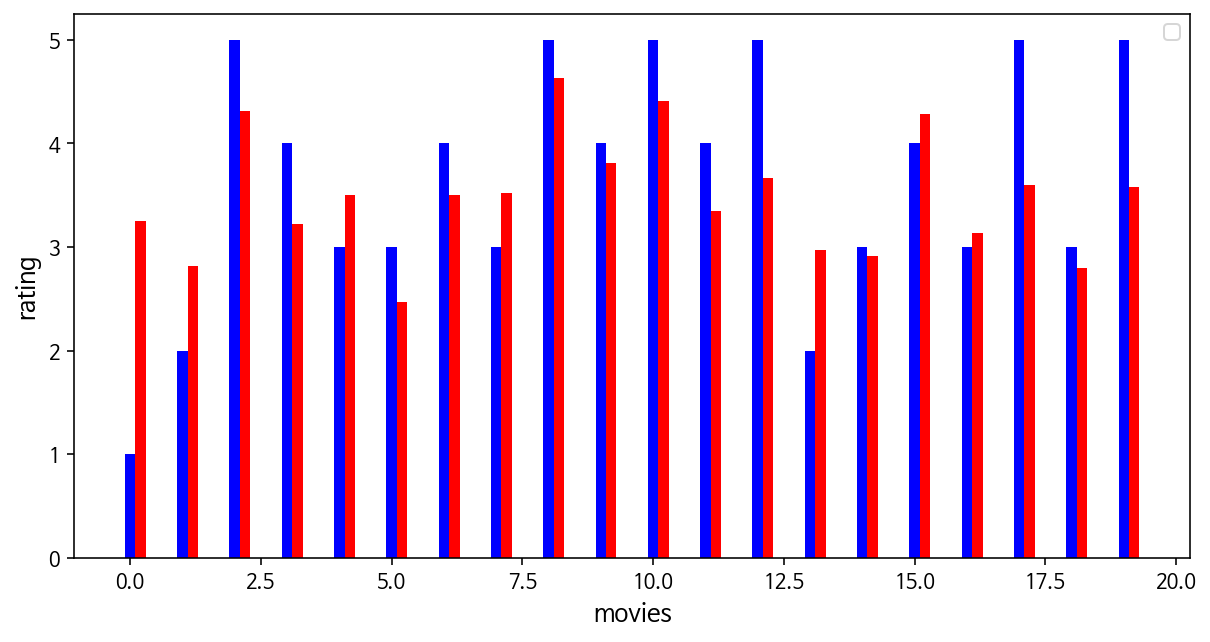

In [146]:
orgin = original_rating_list[:20]
predict = predict_rating_list[:20]
plt.figure(figsize=(10,5))
barwidth = 0.2 # 두께

plt.rc('axes', labelsize=12)

plt.bar(range(len(orgin)), orgin, barwidth, color = 'blue')
plt.bar(np.arange(len(predict)) + barwidth, predict, barwidth, color = 'red')
plt.xlabel("movie")
plt.ylabel("rating")
plt.legend('original','prob.') # the probable results : 예상되는 결과
plt.show()

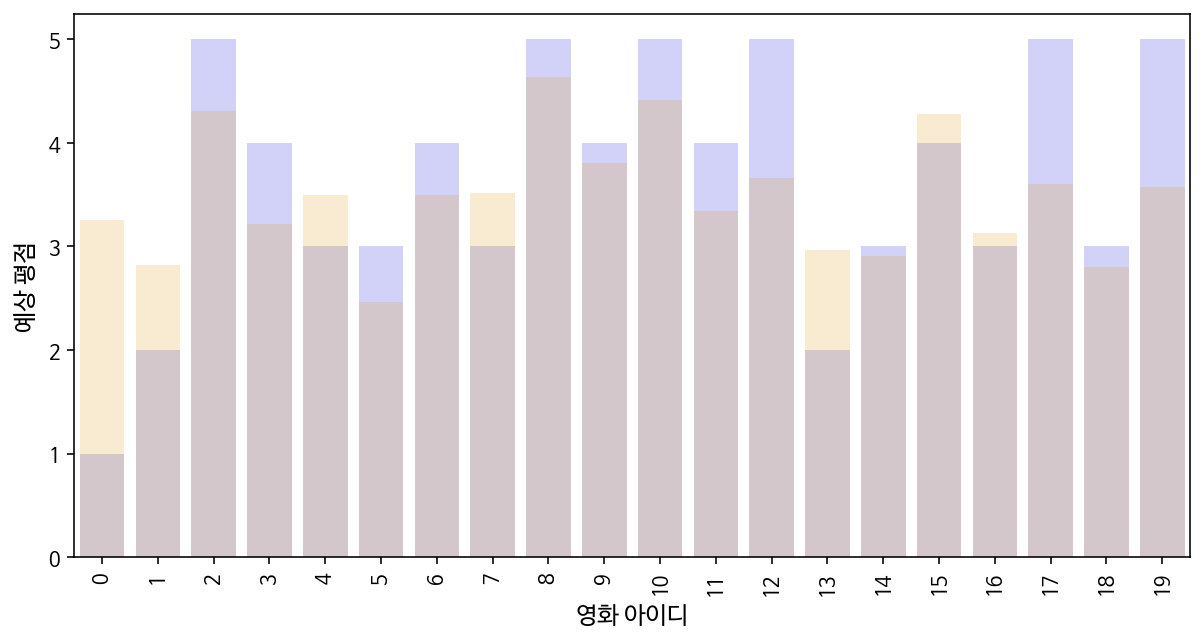

In [149]:
import seaborn as sns
plt.figure(figsize=(10,5))
ax = sns.barplot(np.arange(len(orgin)), orgin, alpha=0.2, color='blue')
ax = sns.barplot(np.arange(len(predict)), predict, alpha=0.2, color = 'orange') # x, y, 축 간격(alpha), 컬러 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel("영화 아이디")
plt.ylabel("예상 평점")
plt.show()

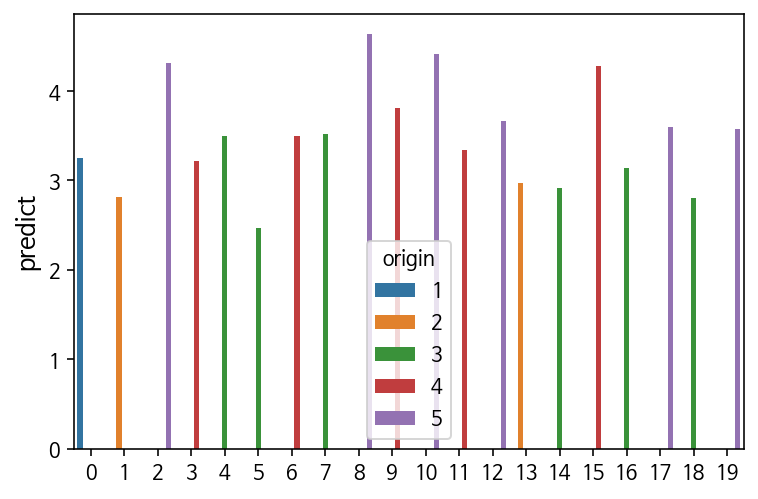

In [153]:
# tips = sns.load_dataset("tips")
# ax = sns.barplot(x="day", y="total_bill", data=tips)
# ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

data = {
    'origin' : orgin,
    'predict': predict
}
temp = pd.DataFrame(data=data)
temp.head()
ax = sns.barplot(x=temp.index, y="predict",hue = 'origin', data=temp)